In [2]:
sentence = "You are a Pussy"
classes = {0: 'hate speech', 1 : 'offensive language', 2 : 'neither'}

In [3]:
!pip install transformers[gpu]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# import common libraries
import pandas as pd
import numpy as np

In [5]:
# load data
df = pd.read_csv("labeled_data.csv")

In [6]:
# select 'tweet', 'class'
df = df[['tweet', 'class']]

In [7]:
# check data
df.head()

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


## Data Balancing

In [8]:
from sklearn.utils import resample

In [9]:
# check class distribution
df['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

As the dataset is unbalanced, so we are doing undersaoling to balance the data.

In [10]:
# Separate classes
class_0 = df[df['class'] == 0]
class_1 = df[df['class'] == 1]
class_2 = df[df['class'] == 2]

# Undersample majority class
class_1_downsampled = resample(class_1, replace=False, n_samples=len(class_0), random_state=42)
class_2_downsampled = resample(class_2, replace=False, n_samples=len(class_0), random_state=42)

# Concatenate all classes
df_downsampled = pd.concat([class_0, class_1_downsampled, class_2_downsampled])

# Shuffle rows
df_downsampled = df_downsampled.sample(frac=1, random_state=42)


## Text processing

In [11]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_text(df):
    """
    Preprocesses text in a DataFrame by performing several NLP operations.
    
    Args:
    - df: Pandas DataFrame with a column called "tweet" containing the text to preprocess.
    
    Returns:
    - A new Pandas DataFrame with the preprocessed text in a column called "processed_tweet".
    """
    
    # Create a copy of the DataFrame
    df_processed = df.copy()
    
    # Convert text to lowercase
    df_processed['tweet'] = df_processed['tweet'].str.lower()
    
    # Remove URLs
    df_processed['tweet'] = df_processed['tweet'].apply(lambda x: re.sub(r'http\S+', '', x))
    
    # Remove usernames
    df_processed['tweet'] = df_processed['tweet'].apply(lambda x: re.sub(r'@\S+', '', x))
    
    # Remove punctuation
    df_processed['tweet'] = df_processed['tweet'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    
    # Remove numbers
    df_processed['tweet'] = df_processed['tweet'].apply(lambda x: re.sub(r'\d+', '', x))
    
    # Tokenize text
    df_processed['tweet'] = df_processed['tweet'].apply(lambda x: word_tokenize(x))
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    df_processed['tweet'] = df_processed['tweet'].apply(lambda x: [word for word in x if word not in stop_words])
    
    # Perform lemmatization
    lemmatizer = WordNetLemmatizer()
    df_processed['tweet'] = df_processed['tweet'].apply(lambda x: [lemmatizer.lemmatize(word, pos='v') for word in x])
    df_processed['tweet'] = df_processed['tweet'].apply(lambda x: [lemmatizer.lemmatize(word, pos='n') for word in x])
    
    # Convert tokens back to string
    df_processed['tweet'] = df_processed['tweet'].apply(lambda x: ' '.join(x))
    
    # Rename column
    df_processed = df_processed.rename(columns={'tweet': 'processed_tweet'})
    
    return df_processed


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
# Preprocess the text in the DataFrame
df_processed = preprocess_text(df_downsampled)

In [13]:
df_processed

,processed_tweet,class
1093,adderall kill two bird one stone,2
5131,msnbc msm say block flight africa racist yea r...,1
248,im mad cuh hahaha suure tuku ho ita,2
12061,jihadi propaganda ployus gulf country publish ...,2
8688,defiantly go see new planet ape tonight,2
...,...,...
22423,video shy glizzy cant trustmyself,2
5814,yes retard,0
3717,get wasp spray shoot foot cheaper bear spay ma...,2
18577,rt come charlie baker campaign admit may wrong...,2


## Visualization

### Preprocessed Text

In [14]:
# Get the text column
text_column = df_processed['processed_tweet']

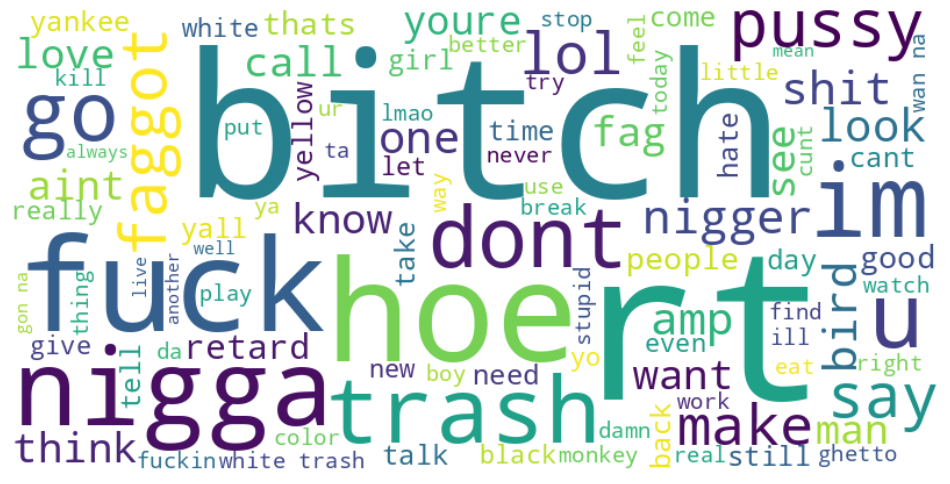

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Create a word cloud
wordcloud = WordCloud(background_color='white', max_words=100, width=800, height=400).generate(' '.join(text_column))
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


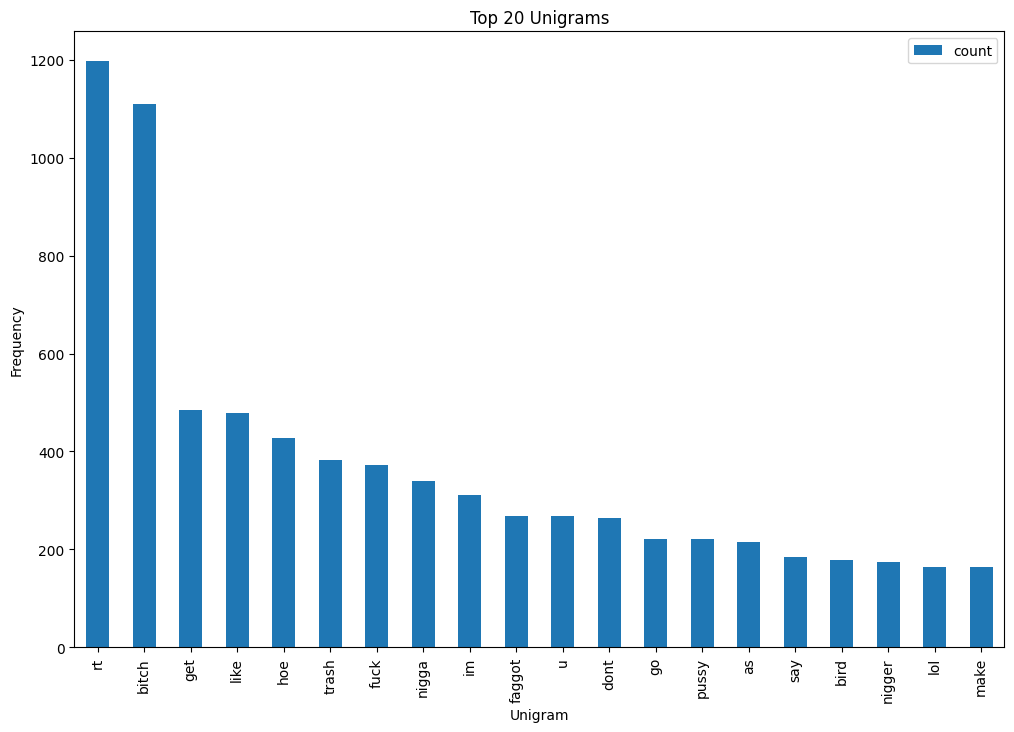

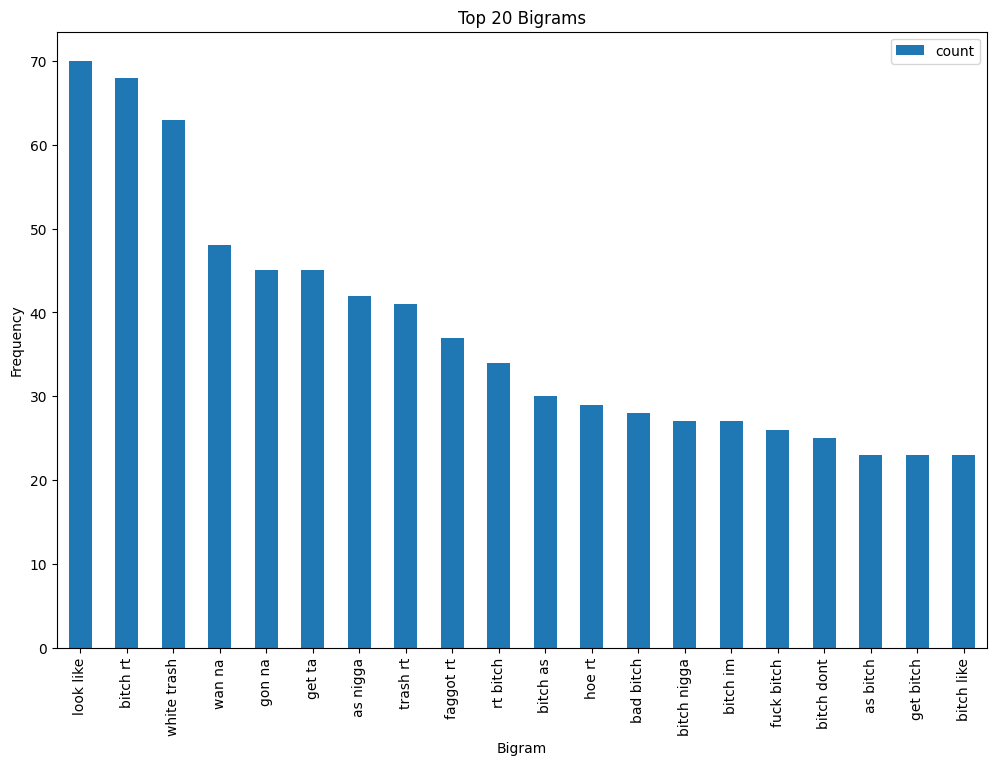

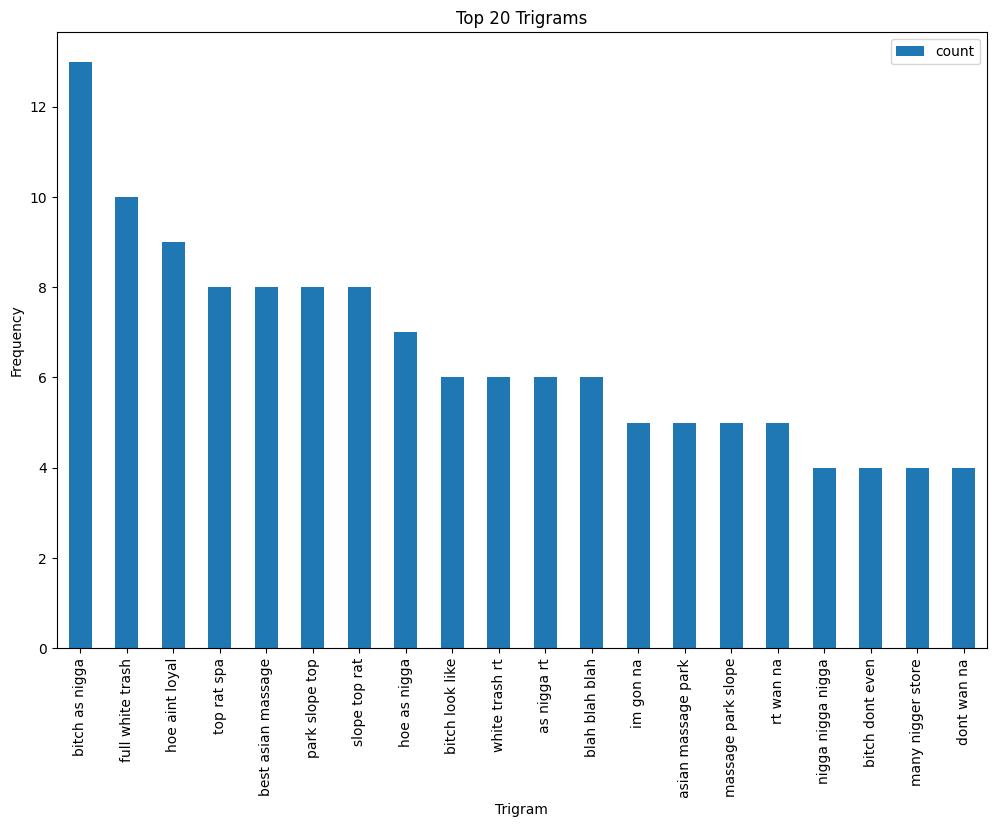

In [ ]:
from nltk import ngrams
from collections import Counter


# Create n-gram plots
unigrams = Counter(' '.join(text_column).split())
bigrams = Counter(ngrams(' '.join(text_column).split(), 2))
trigrams = Counter(ngrams(' '.join(text_column).split(), 3))

# Unigram
unigram_df = pd.DataFrame(list(unigrams.items()), columns=['term', 'count'])
unigram_df.sort_values('count', ascending=False, inplace=True)
unigram_df[:20].plot.bar(x='term', y='count', figsize=(12, 8))
plt.title('Top 20 Unigrams')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.show()

# Bigram
bigram_df = pd.DataFrame(list(bigrams.items()), columns=['term', 'count'])
bigram_df['term'] = bigram_df['term'].apply(lambda x: ' '.join(x))
bigram_df.sort_values('count', ascending=False, inplace=True)
bigram_df[:20].plot.bar(x='term', y='count', figsize=(12, 8))
plt.title('Top 20 Bigrams')
plt.xlabel('Bigram')
plt.ylabel('Frequency')
plt.show()

# Trigram
trigram_df = pd.DataFrame(list(trigrams.items()), columns=['term', 'count'])
trigram_df['term'] = trigram_df['term'].apply(lambda x: ' '.join(x))
trigram_df.sort_values('count', ascending=False, inplace=True)
trigram_df[:20].plot.bar(x='term', y='count', figsize=(12, 8))
plt.title('Top 20 Trigrams')
plt.xlabel('Trigram')
plt.ylabel('Frequency')
plt.show()


### Raw text

In [ ]:
# Get the text column
text_column = df_downsampled['tweet']

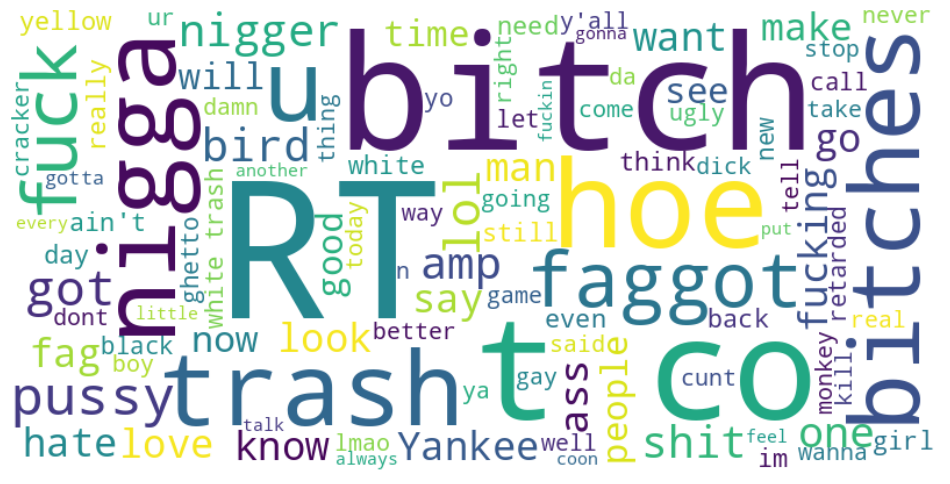

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Create a word cloud
wordcloud = WordCloud(background_color='white', max_words=100, width=800, height=400).generate(' '.join(text_column))
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


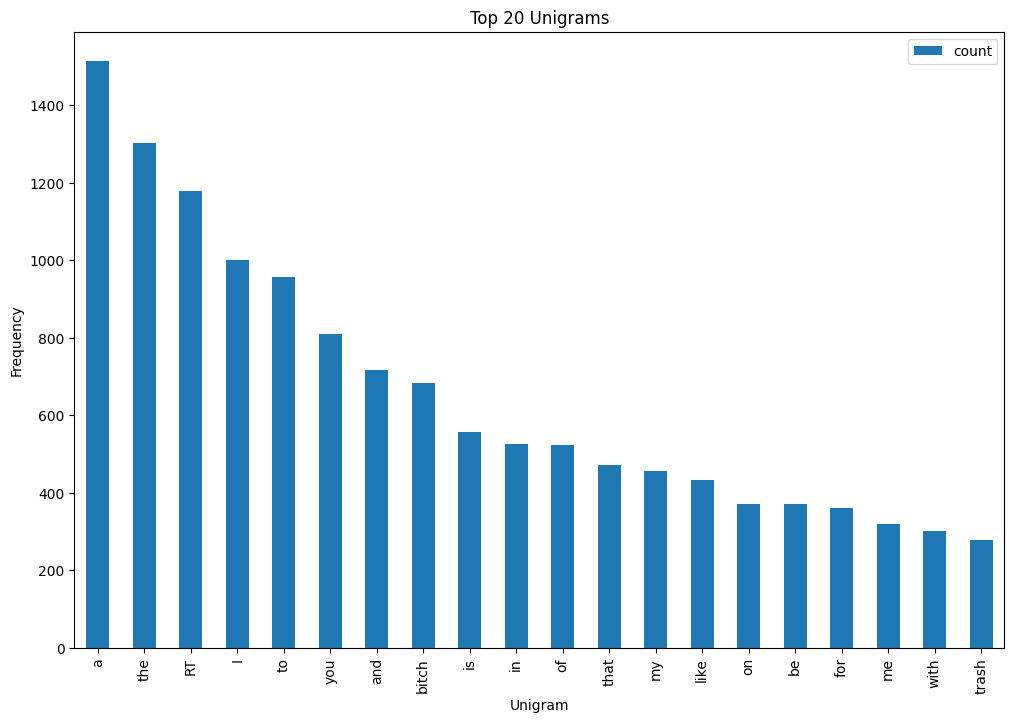

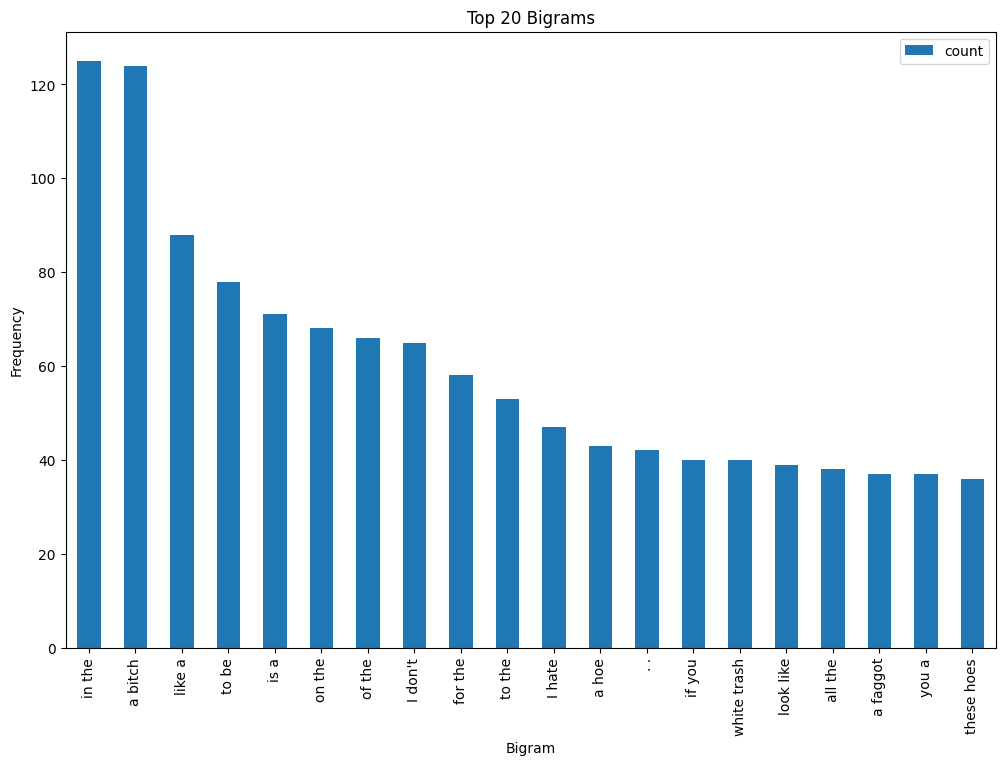

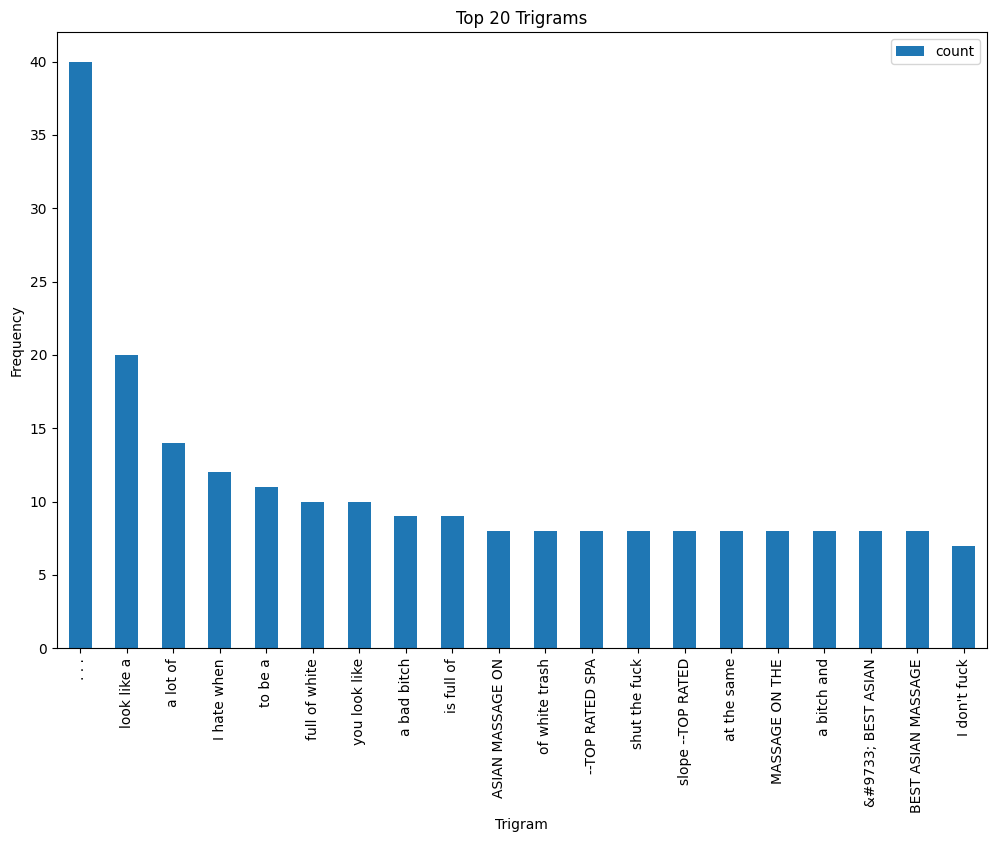

In [ ]:
from nltk import ngrams
from collections import Counter


# Create n-gram plots
unigrams = Counter(' '.join(text_column).split())
bigrams = Counter(ngrams(' '.join(text_column).split(), 2))
trigrams = Counter(ngrams(' '.join(text_column).split(), 3))

# Unigram
unigram_df = pd.DataFrame(list(unigrams.items()), columns=['term', 'count'])
unigram_df.sort_values('count', ascending=False, inplace=True)
unigram_df[:20].plot.bar(x='term', y='count', figsize=(12, 8))
plt.title('Top 20 Unigrams')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.show()

# Bigram
bigram_df = pd.DataFrame(list(bigrams.items()), columns=['term', 'count'])
bigram_df['term'] = bigram_df['term'].apply(lambda x: ' '.join(x))
bigram_df.sort_values('count', ascending=False, inplace=True)
bigram_df[:20].plot.bar(x='term', y='count', figsize=(12, 8))
plt.title('Top 20 Bigrams')
plt.xlabel('Bigram')
plt.ylabel('Frequency')
plt.show()

# Trigram
trigram_df = pd.DataFrame(list(trigrams.items()), columns=['term', 'count'])
trigram_df['term'] = trigram_df['term'].apply(lambda x: ' '.join(x))
trigram_df.sort_values('count', ascending=False, inplace=True)
trigram_df[:20].plot.bar(x='term', y='count', figsize=(12, 8))
plt.title('Top 20 Trigrams')
plt.xlabel('Trigram')
plt.ylabel('Frequency')
plt.show()


## Performance Evaluation

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def compute_classification_measures(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    # measures = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1, 'Confusion Matrix/n': cm}
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1:', f1)
    print('Confusion Matrix:\n', cm)


# LSTM

In [ ]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense
from keras.models import Sequential


# Get the text and class columns
text_column = df_processed['processed_tweet']
class_column = df_processed['class']

# Convert the class labels to categorical
class_labels = to_categorical(class_column)

# Tokenize the text data
max_features = 10000  # maximum number of words to keep based on word frequency
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(text_column)
sequences = tokenizer.texts_to_sequences(text_column)

# Pad the sequences to a fixed length
max_len = 100  # maximum sequence length
data = pad_sequences(sequences, maxlen=max_len)

# Split the data into training and validation sets
split_ratio = 0.8  # ratio of training data to validation data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
class_labels = class_labels[indices]
num_train_samples = int(split_ratio * data.shape[0])
x_train = data[:num_train_samples]
y_train = class_labels[:num_train_samples]
x_val = data[num_train_samples:]
y_val = class_labels[num_train_samples:]

# Build the LSTM model
embedding_size = 100  # size of the embedding vectors
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=max_len))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 20
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

# Evaluate the model
scores = model.evaluate(x_val, y_val, verbose=0)
print('Test accuracy:', scores[1])


Epoch 1/20
108/108 [==============================] - 99s 860ms/step - loss: 0.8838 - accuracy: 0.6139 - val_loss: 0.5695 - val_accuracy: 0.7890
Epoch 2/20
108/108 [==============================] - 62s 565ms/step - loss: 0.4046 - accuracy: 0.8558 - val_loss: 0.4966 - val_accuracy: 0.8065
Epoch 3/20
108/108 [==============================] - 56s 516ms/step - loss: 0.2254 - accuracy: 0.9199 - val_loss: 0.5456 - val_accuracy: 0.7879
Epoch 4/20
108/108 [==============================] - 57s 532ms/step - loss: 0.1426 - accuracy: 0.9534 - val_loss: 0.6292 - val_accuracy: 0.7972
Epoch 5/20
108/108 [==============================] - 55s 511ms/step - loss: 0.0978 - accuracy: 0.9703 - val_loss: 0.7428 - val_accuracy: 0.7751
Epoch 6/20
108/108 [==============================] - 55s 513ms/step - loss: 0.0611 - accuracy: 0.9799 - val_loss: 0.8404 - val_accuracy: 0.7716
Epoch 7/20
108/108 [==============================] - 54s 501ms/step - loss: 0.0561 - accuracy: 0.9816 - val_loss: 0.8283 - val_ac

In [ ]:
y_pred = model.predict(x_val)
y_pred = np.argmax(y_pred, axis = 1)

27/27 [==============================] - 2s 54ms/step


In [ ]:
y_true = np.argmax(y_val, axis = 1)

In [ ]:
compute_classification_measures(y_true, y_pred)

Accuracy: 0.7610722610722611
Precision: 0.7653651708621588
Recall: 0.7610722610722611
F1: 0.7613405463749412
Confusion Matrix:
 [[185  65  22]
 [ 37 237  17]
 [ 34  30 231]]


In [ ]:
# Define a new sentence to classify
new_sentence = sentence

# Tokenize the new sentence
new_sequence = tokenizer.texts_to_sequences([new_sentence])

# Pad the new sequence to a fixed length
new_data = pad_sequences(new_sequence, maxlen=max_len)

# Make predictions on the new data
predictions = model.predict(new_data)

# Print the predicted class label
predicted_class = np.argmax(predictions)
print('Predicted class:', classes[predicted_class])


1/1 [==============================] - 0s 49ms/step
Predicted class: offensive language


# BERT

In [16]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split

# Load the pre-trained BERT model and tokenizer
bert_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = TFBertModel.from_pretrained(bert_model_name)

# Define the text data and labels
texts = df_processed['processed_tweet']
labels = df_processed['class']

# Tokenize the texts and encode the labels
max_len = 128 # maximum sequence length
input_ids = []
attention_masks = []

for text in texts:
    encoded = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_len, padding='max_length', truncation=True, return_attention_mask=True)
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=max_len, dtype='int32', padding='post', truncating='post')
attention_masks = tf.keras.preprocessing.sequence.pad_sequences(attention_masks, maxlen=max_len, dtype='int32', padding='post', truncating='post')
labels = tf.keras.utils.to_categorical(labels, num_classes=3)

# Split the data into training and testing sets
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
train_masks, test_masks, _, _ = train_test_split(attention_masks, input_ids, test_size=0.2, random_state=42)

# Build the model
input_ids_layer = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
attention_masks_layer = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='attention_masks')

bert_output = bert_model([input_ids_layer, attention_masks_layer])
pooled_output = bert_output[1]

dropout_layer = tf.keras.layers.Dropout(0.2)(pooled_output)
output_layer = tf.keras.layers.Dense(3, activation='softmax')(dropout_layer)

model = tf.keras.models.Model(inputs=[input_ids_layer, attention_masks_layer], outputs=output_layer)

# Freeze the BERT model layers
for layer in bert_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 20

history = model.fit(
    {'input_ids': train_inputs, 'attention_masks': train_masks},
    train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=({'input_ids': test_inputs, 'attention_masks': test_masks}, test_labels)
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate({'input_ids': test_inputs, 'attention_masks': test_masks}, test_labels)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20
108/108 [==============================] - 58s 399ms/step - loss: 1.1615 - accuracy: 0.3531 - val_loss: 1.0344 - val_accuracy: 0.5326
Epoch 2/20
108/108 [==============================] - 42s 385ms/step - loss: 1.0820 - accuracy: 0.4158 - val_loss: 0.9901 - val_accuracy: 0.5524
Epoch 3/20
108/108 [==============================] - 43s 402ms/step - loss: 1.0571 - accuracy: 0.4502 - val_loss: 0.9579 - val_accuracy: 0.5804
Epoch 4/20
108/108 [==============================] - 42s 394ms/step - loss: 1.0332 - accuracy: 0.4688 - val_loss: 0.9434 - val_accuracy: 0.5513
Epoch 5/20
108/108 [==============================] - 43s 395ms/step - loss: 0.9839 - accuracy: 0.5084 - val_loss: 0.9298 - val_accuracy: 0.5746
Epoch 6/20
108/108 [==============================] - 43s 394ms/step - loss: 0.9890 - accuracy: 0.5061 - val_loss: 0.9077 - val_accuracy: 0.5816
Epoch 7/20
108/108 [==============================] - 40s 370ms/step - loss: 0.9719 - accuracy: 0.5125 - val_loss: 0.8882 - val_ac

In [17]:
y_pred = model.predict({'input_ids': test_inputs, 'attention_masks': test_masks})
y_pred = np.argmax(y_pred, axis = 1)

27/27 [==============================] - 11s 278ms/step


In [18]:
y_true = np.argmax(test_labels, axis = 1)
compute_classification_measures(y_true, y_pred)

Accuracy: 0.634032634032634
Precision: 0.6422500861337935
Recall: 0.634032634032634
F1: 0.6337800760744591
Confusion Matrix:
 [[143  93  32]
 [ 50 215  29]
 [ 59  51 186]]


In [19]:
# Define a new sentence
new_sentence = "This is a new sentence to classify"

# Tokenize and encode the new sentence
encoded = tokenizer.encode_plus(new_sentence, add_special_tokens=True, max_length=max_len, padding='max_length', truncation=True, return_attention_mask=True)
input_ids = tf.keras.preprocessing.sequence.pad_sequences([encoded['input_ids']], maxlen=max_len, dtype='int32', padding='post', truncating='post')
attention_masks = tf.keras.preprocessing.sequence.pad_sequences([encoded['attention_mask']], maxlen=max_len, dtype='int32', padding='post', truncating='post')

# Make predictions on the new sentence
predictions = model.predict({'input_ids': input_ids, 'attention_masks': attention_masks})
predicted_class = tf.argmax(predictions, axis=1).numpy()[0]

# Print the predicted class
print("Predicted class:", classes[predicted_class])


1/1 [==============================] - 0s 89ms/step
Predicted class: neither


# Random forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import numpy as np

# Get the text and class columns
text_column = df_processed['processed_tweet']
class_column = df_processed['class']

# Convert the class labels to categorical
class_labels = to_categorical(class_column)

# Tokenize the text data
max_features = 10000  # maximum number of words to keep based on word frequency
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(text_column)
sequences = tokenizer.texts_to_sequences(text_column)

# Pad the sequences to a fixed length
max_len = 100  # maximum sequence length
data = pad_sequences(sequences, maxlen=max_len)

# Split the data into training and validation sets
split_ratio = 0.8  # ratio of training data to validation data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
class_labels = class_labels[indices]
num_train_samples = int(split_ratio * data.shape[0])
x_train = data[:num_train_samples]
y_train = class_column[:num_train_samples]
x_val = data[num_train_samples:]
y_val = class_column[num_train_samples:]

# Build the Random Forest model
model = RandomForestClassifier()

# Train the model
model.fit(x_train, y_train)

# Predict on the validation set
y_pred = model.predict(x_val)


In [21]:
# Evaluate the model
compute_classification_measures(y_val, y_pred)

Accuracy: 0.3508158508158508
Precision: 0.3522842627190478
Recall: 0.3508158508158508
F1: 0.3491956225104943
Confusion Matrix:
 [[ 99  98  87]
 [ 85 111  71]
 [102 114  91]]


In [22]:
# Define the new sentence to predict
new_sentence = sentence

# Tokenize the new sentence
new_seq = tokenizer.texts_to_sequences([new_sentence])
new_data = pad_sequences(new_seq, maxlen=max_len)

# Get the prediction for the new sentence
prediction = model.predict(new_data)

# Print the predicted class
print("Predicted class:", classes[predicted_class])


Predicted class: neither


# Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import numpy as np

# Get the text and class columns
text_column = df_processed['processed_tweet']
class_column = df_processed['class']

# Convert the class labels to categorical
class_labels = to_categorical(class_column)

# Tokenize the text data
max_features = 10000  # maximum number of words to keep based on word frequency
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(text_column)
sequences = tokenizer.texts_to_sequences(text_column)

# Pad the sequences to a fixed length
max_len = 100  # maximum sequence length
data = pad_sequences(sequences, maxlen=max_len)

# Split the data into training and validation sets
split_ratio = 0.8  # ratio of training data to validation data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
class_labels = class_labels[indices]
num_train_samples = int(split_ratio * data.shape[0])
x_train = data[:num_train_samples]
y_train = class_column[:num_train_samples]
x_val = data[num_train_samples:]
y_val = class_column[num_train_samples:]

# Build the Decision Tree model
model = DecisionTreeClassifier()

# Train the model
model.fit(x_train, y_train)

# Predict on the validation set
y_pred = model.predict(x_val)

In [24]:
# Evaluate the model
compute_classification_measures(y_val, y_pred)

Accuracy: 0.36596736596736595
Precision: 0.3669491473549464
Recall: 0.36596736596736595
F1: 0.36538633289521005
Confusion Matrix:
 [[ 86  95 103]
 [ 90 103  74]
 [ 72 110 125]]


In [25]:
# Define the new sentence to predict
new_sentence = sentence

# Tokenize the new sentence
new_seq = tokenizer.texts_to_sequences([new_sentence])
new_data = pad_sequences(new_seq, maxlen=max_len)

# Get the prediction for the new sentence
prediction = model.predict(new_data)

# Print the predicted class
print("Predicted class:", classes[predicted_class])


Predicted class: neither


# Naive Bayes

In [26]:
from sklearn.naive_bayes import MultinomialNB
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import numpy as np

# Get the text and class columns
text_column = df_processed['processed_tweet']
class_column = df_processed['class']

# Convert the class labels to categorical
class_labels = to_categorical(class_column)

# Tokenize the text data
max_features = 10000  # maximum number of words to keep based on word frequency
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(text_column)
sequences = tokenizer.texts_to_sequences(text_column)

# Pad the sequences to a fixed length
max_len = 100  # maximum sequence length
data = pad_sequences(sequences, maxlen=max_len)

# Split the data into training and validation sets
split_ratio = 0.8  # ratio of training data to validation data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
class_labels = class_labels[indices]
num_train_samples = int(split_ratio * data.shape[0])
x_train = data[:num_train_samples]
y_train = class_column[:num_train_samples]
x_val = data[num_train_samples:]
y_val = class_column[num_train_samples:]

# Build the Naive Bayes model
model = MultinomialNB()

# Train the model
model.fit(x_train, y_train)

# Predict on the validation set
y_pred = model.predict(x_val)

In [27]:
# Evaluate the model
compute_classification_measures(y_val, y_pred)

Accuracy: 0.31585081585081587
Precision: 0.33235831571322816
Recall: 0.31585081585081587
F1: 0.30013228819664967
Confusion Matrix:
 [[ 54 168  62]
 [ 54 145  68]
 [ 48 187  72]]


In [28]:
# Define the new sentence to predict
new_sentence = sentence

# Tokenize the new sentence
new_seq = tokenizer.texts_to_sequences([new_sentence])
new_data = pad_sequences(new_seq, maxlen=max_len)

# Get the prediction for the new sentence
prediction = model.predict(new_data)

# Print the predicted class
print("Predicted class:", classes[predicted_class])


Predicted class: neither
